# **Hackathon Subject 1: Credit Card Fraud Detection And Prevention**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Description***

The dataset includes anonymized features resulting from a PCA dimensionality reduction process to protect sensitive information. Your task will involve exploring these features, understanding their relationships, and building predictive models to enhance the institution’s fraud detection capabilities.

From the datasource page we have: linkcode Introduction The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

Features V1, V2, ... V28 are the principal components obtained with PCA; The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [51]:
# Import librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [17]:
# data load and preprocessing

df = pd.read_csv('creditcard.csv')
df.info()
df.head()

# # or alternativer using Kaggle:
# from google.colab import files
# files.upload()
# 'new cell'
# !cp kaggle.json ~/.kaggle/
# 'new'
# !chmod 600 ~/.kaggle/kaggle.json
# !mkdir -p ~/.kaggle
# # 1. Créer le dossier cible
# !mkdir -p /content/credit_card_fraud_detection
# # 2. Télécharger le dataset depuis Kaggle
# !kaggle datasets download -d mlg-ulb/creditcardfraud -p /content/credit_card_fraud_detection
# # 3. Décompresser le fichier ZIP dans le même dossier
# !unzip /content/credit_card_fraud_detection/creditcardfraud.zip -d /content/credit_card_fraud_detection
# # 4. Vérifier le contenu extrait
# !ls /content/credit_card_fraud_detection (modifié)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 1 - Exploratory Data Analysis (EDA)

**Time**: Number of seconds elapsed between this transaction and the first transaction in the dataset

**Columns V21 to V28**: Anonymized features resulting from an ACP dimensionality reduction process to protect sensitive information.

**Amount**: Transaction amount

**Class**: This is our target, which takes the value 1 for fraudulent transactions and 0 otherwise

In [18]:
print("\n--- Initial Data Exploration ---")
print(df.info())
print("\nClass Distribution (The Imbalance Problem):")
print(df['Class'].value_counts())
print(f"Fraud Rate: {df['Class'].value_counts()[1] / df.shape[0] * 100:.4f}%")

print('-'*30)
print(df.duplicated().sum())


--- Initial Data Exploration ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807

Observations:
* Size of the dataset : 31 Columns anbd 284807 lines
* Clean dataset with numeric values only
* unbalanced dataset with obnly 492 fraud (0.17%)
* showing 1081 duplicates lines


In [19]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [20]:
df.shape

(284807, 31)

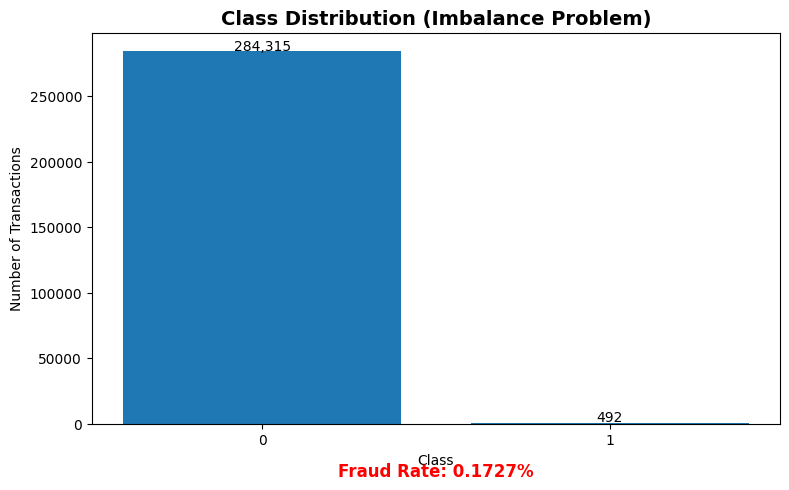

In [21]:
# Visualization of Imbalance


# Sample data
data = {'Class': [0, 1], 'Count': [284315, 492]}
data = pd.DataFrame(data)

# Compute fraud rate
fraud_rate = data.loc[data['Class'] == 1, 'Count'].values[0] / data['Count'].sum() * 100

# --- Bar chart ---
plt.figure(figsize=(8, 5))
plt.bar(data['Class'].astype(str), data['Count'])
plt.title('Class Distribution (Imbalance Problem)', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')

# Annotate counts
for i, val in enumerate(data['Count']):
    plt.text(i, val + 1000, f'{val:,}', ha='center', fontsize=10)

# Display fraud rate below chart
plt.text(0.5, -40000, f'Fraud Rate: {fraud_rate:.4f}%',
         ha='center', fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

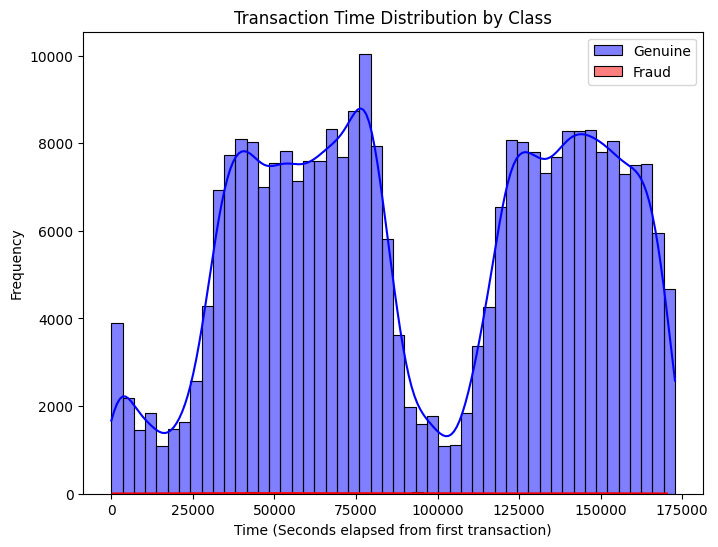

In [22]:
# Visualization of Time vs. Class
plt.figure(figsize=(8, 6))

# Plotting the 'Time' feature for genuine transactions (Class 0)
sns.histplot(df[df['Class'] == 0]['Time'], bins=50, color='blue', label='Genuine', kde=True)
# Overlaying the 'Time' feature for fraudulent transactions (Class 1)
sns.histplot(df[df['Class'] == 1]['Time'], bins=50, color='red', label='Fraud', kde=True)

plt.title('Transaction Time Distribution by Class')
plt.xlabel('Time (Seconds elapsed from first transaction)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

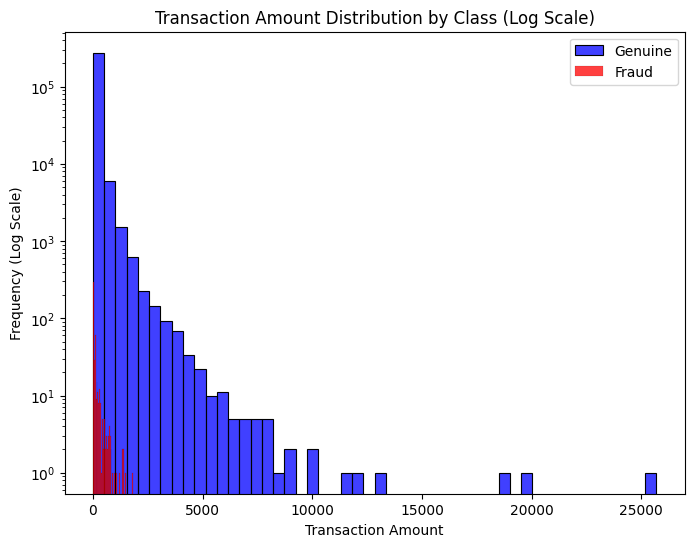

In [23]:
# Visualization of Amount vs. Class

plt.figure(figsize=(8, 6))

# Plotting the 'Amount' feature for genuine transactions (Class 0)
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', label='Genuine', kde=False)
# Overlaying the 'Amount' feature for fraudulent transactions (Class 1)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud', kde=False)

plt.yscale('log') # Set the y-axis to a logarithmic scale
plt.title('Transaction Amount Distribution by Class (Log Scale)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

# 2 - Data Preprocessing

In [24]:
# Cleaning Values

# Number of duplicates before cleaning
print(f"# Number of duplicates before cleaning {df.duplicated().sum()}")
# delete duplicates
df.drop_duplicates(inplace=True)
print(f"# Number of duplicates after cleaning : {df.duplicated().sum()}")


# Number of duplicates before cleaning 1081
# Number of duplicates after cleaning : 0


In [33]:
# normalization or standardization techniques
# as a PCA has been done on the dataset only TIme and Amount need a normalization

# Split features and Target
X = df.drop('Class', axis=1) # Features
y = df['Class']             # Target

# Standardization

scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

# Applying Smote to balance the "Class"
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
new_df = pd.Series(y_res)
# X_res and y_res are now balanced and ready for modelization


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


/tmp/ipython-input-4253872333.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=new_df1, palette=colors)


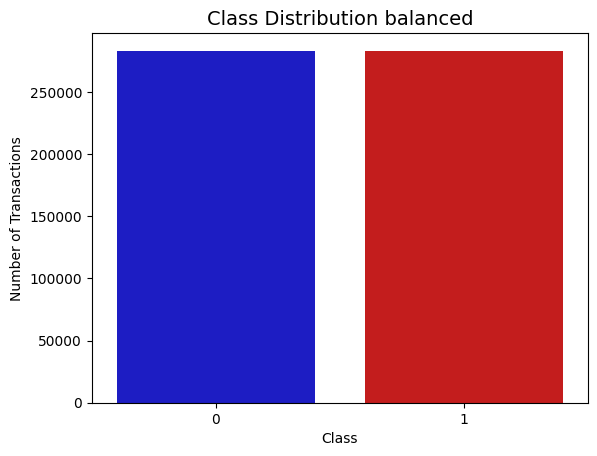

In [36]:
new_df1 = pd.DataFrame(new_df)
print('Distribution of the Classes in the subsample dataset')
print(new_df1['Class'].value_counts()/len(new_df1))

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=new_df1, palette=colors)
plt.title('Class Distribution balanced', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

# **3 - Feature Engineering** :

***- Compare feature means using a t-test***

For each variable, we can test whether the average value is significantly different between:

guenuine (Class = 0)

Fraud (Class = 1)

If the difference is statistically significant, that variable may be important for fraud detection.

In [41]:
# Split the dataset by class
fraud = df[df["Class"] == 1]
guenuine = df[df["Class"] == 0]

# Perform a t-test for each feature
results = {}
for col in df.columns[:-1]:  # exclude 'Class'
    t_stat, p_val = stats.ttest_ind(fraud[col], guenuine[col], equal_var=False)
    results[col] = p_val

# Convert results to a DataFrame and sort by significance
pvals = pd.Series(results).sort_values()
print(pvals.head(10))  # Top 10 most significant variables

V14    2.596913e-133
V4     8.355934e-129
V11    9.849098e-113
V12    5.558652e-107
V10     1.408713e-89
V16     6.514897e-78
V9      1.192731e-75
V3      1.125314e-70
V17     6.494315e-66
V6      2.402860e-56
dtype: float64



If p-value < 0.05, the difference is statistically significant →
that variable helps to distinguish fraudulent from normal transactions
In this case the H0 hypothesys will be rejected

If p-value > 0.05, there is no strong difference between the two groups.
In this case we will not be able to confirm that difference so the hypothesys H0 will be confirmed

->>> The smaller the p-value, the more discriminative the variable is.
In this dataset, variables such as V14, V17, V4, and V11 often appear significant.

***- Visualize feature distributions***

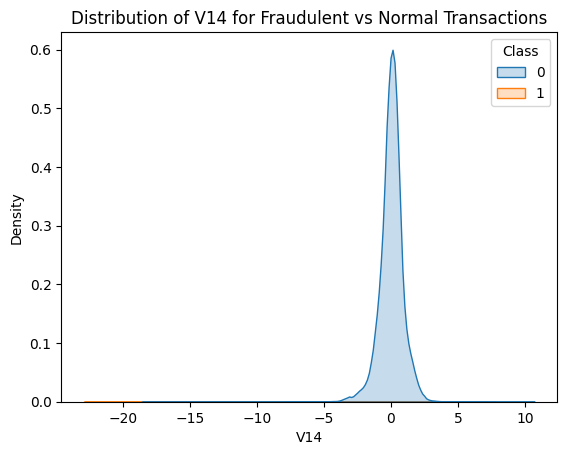

In [37]:
sns.kdeplot(data=df, x="V14", hue="Class", fill=True)
plt.title("Distribution of V14 for Fraudulent vs Normal Transactions")
plt.show()

***- Correlation analysis***

In [38]:
correlations = df.corr()["Class"].abs().sort_values(ascending=False)
print(correlations.head(10))

Class    1.000000
V17      0.313498
V14      0.293375
V12      0.250711
V10      0.206971
V16      0.187186
V3       0.182322
V7       0.172347
V11      0.149067
V4       0.129326
Name: Class, dtype: float64


# **4 - Predictive Modeling:**

The main steps are:

1. Separation of data:

train/test (for example 80%/20%).

2. Training on the set train.

3.Evaluation on the test set with adapted metrics:

Precision (accuracy)

Precision on the fraudulent class (precision)

Rappel (recall)

F1-score (harmonic mean precision/recall)

AUC-ROC (quality of the ranking)

4.Optimization of hyperparameters (e.g. with GridSearchCV).

## ***Logistic Regression:***

In [42]:
# X_res et y_res are ready afer preprocessing and SMOTE

# 1. Split on train/test

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 2. Model training

lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_train, y_train)

# 3. Predictions

y_pred = lr.predict(X_test)

y_prob = lr.predict_proba(X_test)[:,1]

# 4. Evaluation

print("Classification Report :\n", classification_report(y_test, y_pred))

print("Confusion Matrice  :\n", confusion_matrix(y_test, y_pred))

print("AUC-ROC :", roc_auc_score(y_test, y_prob))



Classification Report :
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     56463
           1       0.97      0.92      0.94     56839

    accuracy                           0.95    113302
   macro avg       0.95      0.95      0.95    113302
weighted avg       0.95      0.95      0.95    113302

Confusion Matrice  :
 [[54996  1467]
 [ 4735 52104]]
AUC-ROC : 0.9885866875068968


**In summary:**

- Good fraud detection requires a balance between accuracy and recall, because every false positive or false negative has a cost.

- Logistic regression, although simple, can give a good compromise and often serves as a solid baseline.

- It is often useful to adjust the classification threshold (by default 0.5) to find this optimal compromise according to company policy.

We could adjust the threshold:

By default, logistic regression classifies an observation as fraud if the predicted probability is 0.5. But in a context where fraud is rare and costly, this threshold is not always optimal.

By lowering the threshold (ex: 0.3), we detect more fraud with a decrease in 'recall' but we would also increase false alerts and we would have less 'precision'.
By increasing the threshold (ex: 0.7), we reduce false alerts, increase in 'precision' but we miss more frauds, decrease in 'recall'.

In [52]:
# Exemple de test sur plusieurs seuils et faire un choix sur le meilleur en fonction du but recherché :

# Model prediction probabylity

y_probs = lr.predict_proba(X_test)[:,1]

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:

    y_pred_thresh = (y_probs >= thresh).astype(int)

    precision = precision_score(y_test, y_pred_thresh)

    recall = recall_score(y_test, y_pred_thresh)

    f1 = f1_score(y_test, y_pred_thresh)

    results.append((thresh, precision, recall, f1))


# Affichage des résultats

print("Threshold | Precision | Recall | F1-score")

for thresh, precision, recall, f1 in results:

    print(f"{thresh:.2f}      | {precision:.3f}    | {recall:.3f} | {f1:.3f}")





Threshold | Precision | Recall | F1-score
0.10      | 0.822    | 0.986 | 0.896
0.15      | 0.874    | 0.976 | 0.922
0.20      | 0.906    | 0.966 | 0.935
0.25      | 0.928    | 0.955 | 0.942
0.30      | 0.944    | 0.946 | 0.945
0.35      | 0.954    | 0.939 | 0.946
0.40      | 0.962    | 0.931 | 0.946
0.45      | 0.968    | 0.924 | 0.945
0.50      | 0.973    | 0.917 | 0.944
0.55      | 0.977    | 0.909 | 0.942
0.60      | 0.980    | 0.903 | 0.940
0.65      | 0.984    | 0.897 | 0.938
0.70      | 0.986    | 0.891 | 0.936
0.75      | 0.988    | 0.885 | 0.934
0.80      | 0.990    | 0.880 | 0.932
0.85      | 0.992    | 0.873 | 0.929


How to choose?

It is necessary to identify the threshold where the F1-score is maximal, for a good compromise.

If we want to prioritize fraud detection (recall), we must choose a lower threshold.

If we want to reduce false alarms ("accuracy"), we must choose a higher threshold.

